In [11]:
import pandas as pd
import bs4 as bs 
import numpy as np
import os
from PIL import Image
import codecs, json
import pandas as pd
import requests
# pprint is pretty print (formats the JSON)
from pprint import pprint
from IPython.display import HTML
import json
import matplotlib.pyplot as plt
import re

In [2]:
hashtag = "#23Feb"
start = "2019-02-23"
end = "2019-02-24"

In [3]:
import got.manager.TweetCriteria 
import got.manager.TweetManager

tweetCriteria = got.manager.TweetCriteria().setQuerySearch(hashtag).setSince(start).setUntil(end).setTopTweets(True)#.setMaxTweets(100)
tweets = got.manager.TweetManager.getTweets(tweetCriteria)

In [4]:
len(tweets)

762

In [8]:
df = pd.DataFrame()
df['username'] = ''
df['date'] = ''
df['retweets'] = '' 
df['favorites'] = ''
df['text'] = ''
df['geo'] = ''
df['mentions'] = ''
df['hashtags'] = ''
df['id'] = ''
df['permalink'] = ''

In [9]:
# put tweets in data frame
idx = 0
for t in tweets:
  
    df.loc[idx,'username'] = t.username
    df.loc[idx,'date'] = t.date.strftime("%Y-%m-%d %H:%M")
    df.loc[idx,'retweets'] = t.retweets
    df.loc[idx,'favorites'] = t.favorites
    df.loc[idx,'text'] = t.text
    df.loc[idx,'geo'] = t.geo
    df.loc[idx,'mentions'] = t.mentions
    df.loc[idx,'hashtags'] = t.hashtags
    df.loc[idx,'id'] = t.id
    df.loc[idx,'permalink'] = t.permalink
    idx += 1

In [19]:
def clean_tweet(df):
    idx = 0
    for t in tweets:
    
        text = re.sub('Retweeted.*\):','',t.text)
        text = re.sub('(http.*$)','',text)
        text = re.sub('(pic.twitter.*$)','',text)
        text = re.sub('([@#][\w_-]+)','',text)
        text = re.sub('([@] [^ ]+)','', text)
        text = re.sub('([#] [^ ]+)','', text)
        text = re.sub('[^\w]', ' ', text)
        text = re.sub('(['  '.*])', ' ', text)
        
        df.loc[idx,'text'] = text
        idx += 1
        
clean_tweet(df)

In [21]:
def compile_doc(df):
    id_count = 0
    documents = {'documents': []}
    for text in df['text']:
    
        documents['documents'].append({'id': '{}'.format(id_count), 'language': 'es', 'text': text})
        id_count += 1
    
    return documents


documents = compile_doc(df)

In [22]:
subscription_key = 'e41c34b3bcf841d0859d6aba9e8e1494'
assert subscription_key
text_analytics_base_url = "https://westcentralus.api.cognitive.microsoft.com/text/analytics/v2.1/"
language_api_url = text_analytics_base_url + "languages"
sentiment_api_url = text_analytics_base_url + "sentiment"

headers   = {"Ocp-Apim-Subscription-Key": subscription_key}
response  = requests.post(sentiment_api_url, headers=headers, json=documents)
sentiments = response.json()

In [23]:
df['MS_sentiment'] = ''
idx = 0
for entry in sentiments['documents']:
    
    df.loc[idx,'sentiment'] = entry['score']
    idx += 1

In [24]:
# change date to datetime object
df['date'] = pd.to_datetime(df.date)

In [25]:
df = df.reset_index()

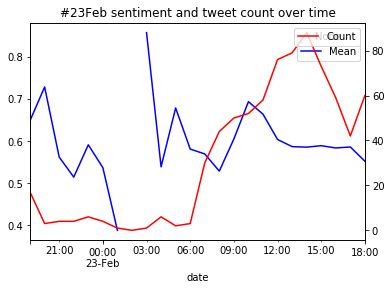

In [26]:
df = df.set_index('date')
avg_sent_per_day = df.sentiment.resample('h').mean()
count_sent_per_day = df.sentiment.resample('h').count()
avg_sent_per_day.name = "Mean"
count_sent_per_day.name = "Count"
avg_sent_per_day.plot(color = 'blue', grid=False)
plt.title(hashtag + ' ' + 'sentiment and tweet count over time')
plt.legend(loc='upper left')
plt.xlabel('Hour')
count_sent_per_day.plot(color='red',grid=False,secondary_y=True)
plt.legend(loc='upper right')
plt.show()